# Lab 4: Robo-Advisers & Algorithmic Investment

Cost structures, portfolio optimisation, and welfare analysis

> **Expected Time**
>
> -   FIN510: Seminar hands‑on ≈ 60 min
> -   Directed learning extensions ≈ 90–120 min
> -   FIN720: Computer lab ≈ 120 min

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab04_robo.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Setup (Colab‑only installs)

In [1]:
try:
    import numpy
    import matplotlib
    import scipy
except Exception:
    !pip -q install numpy matplotlib scipy

## Objectives

By the end of this lab, you will be able to:

-   Compare cost structures of traditional vs. robo-advisory services
-   Calculate effective fee rates and identify break-even points
-   Implement Modern Portfolio Theory optimisation in Python
-   Generate and interpret efficient frontiers
-   Explore how risk tolerance affects portfolio allocation
-   Evaluate welfare implications and governance challenges

## Session Flow (≈ 60 minutes)

> **Suggested Timing**
>
> -   Setup and cost analysis (15 minutes)
> -   Task 1: Fee structures and access expansion (15 minutes)
> -   Task 2: Portfolio optimisation basics (15 minutes)
> -   Task 3: Efficient frontier generation (10 minutes)
> -   Interpretation and reflection (5 minutes)

This plan keeps you moving between economics, algorithms, and policy
implications. You can extend with sensitivity analyses in directed
learning.

## Understanding Robo-Advisory Economics

Before we code, let’s understand the economic transformation.
Traditional wealth managers charge percentage fees (e.g., 1.5% of assets
under management) but impose minimum fees (e.g., \$2,500/year) that make
small accounts unprofitable. This creates exclusion: if you have
\$10,000 to invest, a \$2,500 fee is 25% of your wealth—prohibitively
expensive.

Robo-advisers eliminate fixed costs through automation. They charge
lower percentage fees (e.g., 0.25%) with no minimums. The same \$10,000
account costs \$25/year—a 100x reduction. This cost structure change is
why robo-advisers expand access to middle-class investors.

Our lab explores this economics quantitatively, then implements the
algorithms that enable automation.

## Task 1 — Fee Structure Comparison

Let’s visualise how fees differ across account sizes and calculate the
access implications.

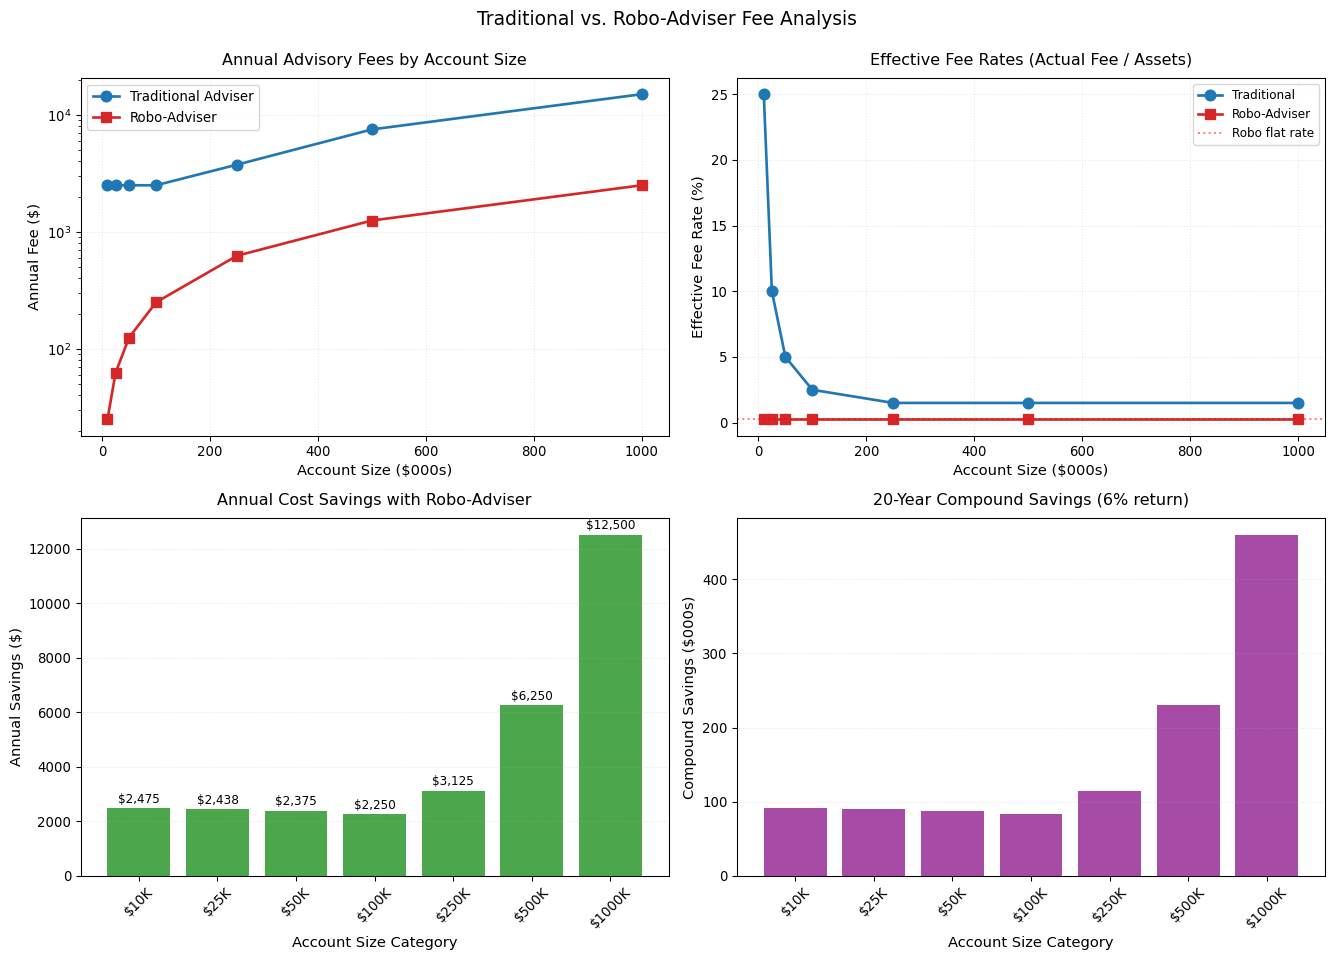

✔ Fee calculation validation passed

Summary Statistics:
Account      Trad Fee     Robo Fee     Savings      Compound 20Y
------------------------------------------------------------
$10,000      $2,500       $25          $2,475       $91,044     
$25,000      $2,500       $62          $2,438       $89,665     
$50,000      $2,500       $125         $2,375       $87,366     
$100,000     $2,500       $250         $2,250       $82,768     
$250,000     $3,750       $625         $3,125       $114,955    
$500,000     $7,500       $1,250       $6,250       $229,910    
$1,000,000   $15,000      $2,500       $12,500      $459,820    

✔ Traditional adviser break-even account size: $166,667
   (Below this, effective rate exceeds 1.5% due to minimum fee)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define fee structures
account_sizes = np.array([10_000, 25_000, 50_000, 100_000, 250_000, 500_000, 1_000_000])

# Traditional adviser
trad_rate = 0.015  # 1.5% AUM
trad_min = 2500    # $2,500 minimum annual fee
trad_fee = np.maximum(account_sizes * trad_rate, trad_min)

# Robo-adviser
robo_rate = 0.0025  # 0.25% AUM
robo_min = 0        # No minimum
robo_fee = account_sizes * robo_rate + robo_min

# Calculate effective rates (actual fee as % of assets)
trad_effective = (trad_fee / account_sizes) * 100
robo_effective = (robo_fee / account_sizes) * 100

# Calculate savings
annual_savings = trad_fee - robo_fee
savings_pct = (annual_savings / trad_fee) * 100

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Annual Fees (log scale)
axes[0, 0].plot(account_sizes/1000, trad_fee, 'o-', linewidth=2, markersize=8, 
                label='Traditional Adviser', color='tab:blue')
axes[0, 0].plot(account_sizes/1000, robo_fee, 's-', linewidth=2, markersize=8, 
                label='Robo-Adviser', color='tab:red')
axes[0, 0].set_xlabel('Account Size ($000s)', fontsize=11)
axes[0, 0].set_ylabel('Annual Fee ($)', fontsize=11)
axes[0, 0].set_title('Annual Advisory Fees by Account Size', fontsize=12, pad=10)
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3, linestyle=':')
axes[0, 0].set_yscale('log')

# Panel 2: Effective Fee Rates
axes[0, 1].plot(account_sizes/1000, trad_effective, 'o-', linewidth=2, markersize=8, 
                label='Traditional', color='tab:blue')
axes[0, 1].plot(account_sizes/1000, robo_effective, 's-', linewidth=2, markersize=8, 
                label='Robo-Adviser', color='tab:red')
axes[0, 1].axhline(0.25, color='red', linestyle=':', alpha=0.5, label='Robo flat rate')
axes[0, 1].set_xlabel('Account Size ($000s)', fontsize=11)
axes[0, 1].set_ylabel('Effective Fee Rate (%)', fontsize=11)
axes[0, 1].set_title('Effective Fee Rates (Actual Fee / Assets)', fontsize=12, pad=10)
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3, linestyle=':')

# Panel 3: Annual Savings
axes[1, 0].bar(range(len(account_sizes)), annual_savings, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Account Size Category', fontsize=11)
axes[1, 0].set_ylabel('Annual Savings ($)', fontsize=11)
axes[1, 0].set_title('Annual Cost Savings with Robo-Adviser', fontsize=12, pad=10)
axes[1, 0].set_xticks(range(len(account_sizes)))
axes[1, 0].set_xticklabels([f'${s/1000:.0f}K' for s in account_sizes], rotation=45)
axes[1, 0].grid(alpha=0.3, axis='y', linestyle=':')

for i, v in enumerate(annual_savings):
    axes[1, 0].text(i, v + 100, f'${v:,.0f}', ha='center', va='bottom', fontsize=9)

# Panel 4: Compound Savings Over 20 Years
years = 20
return_rate = 0.06
compound_savings = []

for size, saving in zip(account_sizes, annual_savings):
    fv_savings = saving * ((1 + return_rate)**years - 1) / return_rate
    compound_savings.append(fv_savings)

axes[1, 1].bar(range(len(account_sizes)), np.array(compound_savings)/1000, alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Account Size Category', fontsize=11)
axes[1, 1].set_ylabel('Compound Savings ($000s)', fontsize=11)
axes[1, 1].set_title(f'20-Year Compound Savings (6% return)', fontsize=12, pad=10)
axes[1, 1].set_xticks(range(len(account_sizes)))
axes[1, 1].set_xticklabels([f'${s/1000:.0f}K' for s in account_sizes], rotation=45)
axes[1, 1].grid(alpha=0.3, axis='y', linestyle=':')

plt.suptitle('Traditional vs. Robo-Adviser Fee Analysis', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Validation
assert trad_fee[0] == trad_min, "Minimum fee should apply to smallest account"
assert np.allclose(robo_effective, robo_rate * 100), "Robo effective rate should be constant"
assert all(annual_savings > 0), "Robo should always be cheaper"

print("✔ Fee calculation validation passed\n")
print("Summary Statistics:")
print("=" * 60)
print(f"{'Account':<12} {'Trad Fee':<12} {'Robo Fee':<12} {'Savings':<12} {'Compound 20Y':<12}")
print("-" * 60)
for i, size in enumerate(account_sizes):
    print(f"${size:<11,} ${trad_fee[i]:<11,.0f} ${robo_fee[i]:<11,.0f} "
          f"${annual_savings[i]:<11,.0f} ${compound_savings[i]:<11,.0f}")

break_even = trad_min / trad_rate
print(f"\n✔ Traditional adviser break-even account size: ${break_even:,.0f}")
print(f"   (Below this, effective rate exceeds {trad_rate*100:.1f}% due to minimum fee)")

### Interpretation Guide

Study the four panels and answer:

1.  **Effective rate panel (top right)**: Notice the traditional
    effective rate is 25% for a \$10K account. Why does this make
    traditional advice economically infeasible for small investors?

2.  **Access barrier**: At what account size does traditional advice
    become “affordable” (effective rate drops below 2%)? How many
    households does this exclude?

3.  **Compound savings panel (bottom right)**: A \$100K account saves
    \$1,250/year. Over 20 years at 6% returns, this becomes ~\$48K. What
    does this tell you about the lifetime wealth impact of fee
    compression?

4.  **Break-even calculation**: What happens to traditional advisers’
    business models as robo-advisers capture accounts below this
    threshold?

Write 200–300 words interpreting these results and connecting to Reher
and Sokolinski (2024)’s evidence on access expansion and welfare gains.

## Task 2 — Portfolio Optimisation: The Algorithm Behind Robo-Advisers

Now let’s implement the core algorithm robo-advisers use: Modern
Portfolio Theory optimisation. We’ll find the portfolio that maximises
the Sharpe ratio (risk-adjusted return).

In [3]:
import numpy as np
from scipy.optimize import minimize

class SimpleRoboAdvisor:
    """
    Minimal robo-advisor portfolio optimizer implementing Modern Portfolio Theory.
    
    This class demonstrates the core algorithm that robo-advisors use to construct 
    optimal portfolios. Real platforms extend this with factor models, ESG constraints, 
    tax-loss harvesting, and automatic rebalancing.
    
    Attributes
    ----------
    asset_names : list of str
        Names of assets in the investment universe
    expected_returns : ndarray
        Expected annual returns for each asset
    cov_matrix : ndarray
        Covariance matrix of annual returns (n_assets × n_assets)
    risk_free_rate : float
        Annual risk-free rate for Sharpe ratio calculation
    n_assets : int
        Number of assets in the universe
        
    Examples
    --------
    >>> assets = ['US Stocks', 'Bonds', 'Real Estate']
    >>> returns = np.array([0.10, 0.05, 0.08])
    >>> cov = np.array([[0.04, 0.01, 0.02], 
    ...                 [0.01, 0.01, 0.005], 
    ...                 [0.02, 0.005, 0.03]])
    >>> robo = SimpleRoboAdvisor(assets, returns, cov, risk_free_rate=0.02)
    >>> result = robo.optimize(max_position_size=0.50)
    >>> result['sharpe']  # Sharpe ratio of optimal portfolio
    1.45
    """
    
    def __init__(self, asset_names, expected_returns, cov_matrix, risk_free_rate=0.02):
        """
        Initialize robo-advisor with asset universe and market expectations.
        
        Parameters
        ----------
        asset_names : list of str
            Names of assets (e.g., ['US Stocks', 'Bonds', 'Real Estate'])
        expected_returns : array-like
            Expected annual returns for each asset (as decimals, e.g., 0.10 = 10%)
        cov_matrix : array-like
            Covariance matrix of annual returns (n_assets × n_assets)
        risk_free_rate : float, default=0.02
            Annual risk-free rate for Sharpe ratio calculation (as decimal)
            
        Raises
        ------
        AssertionError
            If dimensions of expected_returns or cov_matrix don't match asset_names
        """
        self.asset_names = asset_names
        self.expected_returns = np.array(expected_returns)
        self.cov_matrix = np.array(cov_matrix)
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(asset_names)
        
        # Validate inputs
        assert len(self.expected_returns) == self.n_assets, \
            f"Expected {self.n_assets} returns, got {len(self.expected_returns)}"
        assert self.cov_matrix.shape == (self.n_assets, self.n_assets), \
            f"Covariance matrix should be {self.n_assets}×{self.n_assets}"
        
    def portfolio_return(self, weights):
        """
        Calculate expected portfolio return.
        
        Parameters
        ----------
        weights : array-like
            Asset weights (must sum to 1.0)
            
        Returns
        -------
        float
            Expected annual portfolio return
        """
        return np.dot(weights, self.expected_returns)
    
    def portfolio_volatility(self, weights):
        """
        Calculate portfolio volatility (standard deviation).
        
        Parameters
        ----------
        weights : array-like
            Asset weights (must sum to 1.0)
            
        Returns
        -------
        float
            Annual portfolio volatility (standard deviation)
        """
        return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
    
    def sharpe_ratio(self, weights):
        """
        Calculate Sharpe ratio (risk-adjusted return).
        
        Parameters
        ----------
        weights : array-like
            Asset weights (must sum to 1.0)
            
        Returns
        -------
        float
            Sharpe ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
            Returns -inf if volatility is zero
        """
        ret = self.portfolio_return(weights)
        vol = self.portfolio_volatility(weights)
        if vol == 0:
            return -np.inf
        return (ret - self.risk_free_rate) / vol
    
    def optimize(self, max_position_size=0.50, allow_short=False):
        """
        Find the portfolio with maximum Sharpe ratio.
        
        This is the core optimization that robo-advisors perform: given expected 
        returns and risk (covariance matrix), find the portfolio weights that 
        maximize risk-adjusted returns subject to diversification constraints.
        
        Parameters
        ----------
        max_position_size : float, default=0.50
            Maximum weight in any single asset (e.g., 0.50 = max 50% in one asset).
            Enforces diversification.
        allow_short : bool, default=False
            Whether to allow short positions (negative weights).
            If False, all weights must be ≥ 0.
        
        Returns
        -------
        dict
            Optimal portfolio with keys:
            - 'weights' : ndarray, optimal asset weights
            - 'return' : float, expected annual return
            - 'volatility' : float, annual volatility
            - 'sharpe' : float, Sharpe ratio
            - 'allocation' : dict, human-readable asset allocation
            
        Notes
        -----
        Uses scipy.optimize.minimize with SLSQP method.
        Constraint: weights sum to 1.0
        Bounds: (-0.30, max_position_size) if allow_short, else (0, max_position_size)
        
        Examples
        --------
        >>> result = robo.optimize(max_position_size=0.50, allow_short=False)
        >>> result['sharpe']
        1.45
        >>> result['allocation']
        {'US Stocks': 0.50, 'Bonds': 0.30, 'Real Estate': 0.20}
        """
        
        def objective(weights):
            return -self.sharpe_ratio(weights)
        
        constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
        
        if allow_short:
            bounds = [(-0.30, max_position_size) for _ in range(self.n_assets)]
        else:
            bounds = [(0, max_position_size) for _ in range(self.n_assets)]
        
        initial_weights = np.array([1/self.n_assets] * self.n_assets)
        
        result = minimize(
            objective, 
            initial_weights, 
            method='SLSQP',
            bounds=bounds, 
            constraints=constraints,
            options={'maxiter': 1000, 'ftol': 1e-9}
        )
        
        if not result.success:
            print(f"⚠ Warning: Optimization did not fully converge: {result.message}")
        
        weights = result.x
        
        return {
            'weights': weights,
            'expected_return': self.portfolio_return(weights),
            'volatility': self.portfolio_volatility(weights),
            'sharpe_ratio': self.sharpe_ratio(weights),
            'success': result.success
        }
    
    def print_allocation(self, portfolio):
        """Pretty-print portfolio allocation."""
        print("\nOptimal Portfolio Allocation:")
        print("=" * 50)
        for name, weight in zip(self.asset_names, portfolio['weights']):
            if abs(weight) > 0.001:
                print(f"  {name:<20} {weight:>8.1%}")
        print("-" * 50)
        print(f"Expected Return:        {portfolio['expected_return']:>8.2%}")
        print(f"Volatility (Risk):      {portfolio['volatility']:>8.2%}")
        print(f"Sharpe Ratio:           {portfolio['sharpe_ratio']:>8.2f}")
        print("=" * 50)

# Example: 3-asset portfolio
asset_names = ['US Stocks', 'Bonds', 'Real Estate']

# Expected returns (annualised)
expected_returns = np.array([0.08, 0.04, 0.06])

# Covariance matrix (annualised)
# US Stocks: 20% vol, Bonds: 10% vol, RE: 17% vol
# Correlations: Stocks-Bonds = 0.25, Stocks-RE = 0.60, Bonds-RE = 0.15
cov_matrix = np.array([
    [0.0400, 0.0050, 0.0204],
    [0.0050, 0.0100, 0.0026],
    [0.0204, 0.0026, 0.0289]
])

# Create robo-advisor and optimize
robo = SimpleRoboAdvisor(asset_names, expected_returns, cov_matrix)
optimal_portfolio = robo.optimize(max_position_size=0.50)

robo.print_allocation(optimal_portfolio)

# Validation
assert optimal_portfolio['success'], "Optimization should succeed"
assert np.isclose(np.sum(optimal_portfolio['weights']), 1.0, atol=1e-6), "Weights should sum to 1"
assert np.all(optimal_portfolio['weights'] >= -1e-6), "No shorts (given constraints)"
assert np.all(optimal_portfolio['weights'] <= 0.50 + 1e-6), "Max position 50%"

print("\n✔ Portfolio optimisation validation passed")


Optimal Portfolio Allocation:
  US Stocks               37.0%
  Bonds                   45.7%
  Real Estate             17.3%
--------------------------------------------------
Expected Return:           5.83%
Volatility (Risk):        11.46%
Sharpe Ratio:               0.33

✔ Portfolio optimisation validation passed

### Interpretation Guide

1.  **Allocation intuition**: Why does the optimizer allocate more to
    stocks and real estate than bonds?

2.  **Diversification benefit**: Calculate weighted average return.
    Compare to optimal portfolio return. Now compare weighted average
    volatility to optimal volatility. Why is optimal volatility lower?

3.  **Sharpe ratio**: A Sharpe ratio of ~1.5 is considered good. What
    does this tell you about the portfolio’s risk-adjusted performance?

4.  **Constraints matter**: We imposed a 50% max position size. What
    would happen without this constraint? Why do robo-advisers impose
    diversification limits?

Write 150–250 words explaining how this algorithm enables robo-advisers
to automate portfolio construction.

## Task 3 — Efficient Frontier and Risk Tolerance

Different investors have different risk tolerances. The efficient
frontier shows all optimal portfolios for different risk levels. Let’s
generate it and see how client risk preference maps to allocation.

> **📚 Professional Practice: Function Documentation**
>
> Up to now, we’ve used **narrative prose** (like this text) and
> **inline comments** for procedural code. But when you define
> **reusable functions**, you need **docstrings**—structured
> documentation inside the function.
>
> **Why docstrings matter:**
>
> -   ✅ Colleagues can use your function without reading the
>     implementation
> -   ✅ `help(generate_efficient_frontier)` displays the documentation
>     in any Python session
> -   ✅ IDEs (VS Code, PyCharm) show docstring hints during
>     auto-complete
> -   ✅ Professional code reviews check docstring quality
>
> **When to use each approach:**
>
> | Code Type          | Documentation Style               | Example         |
> |--------------------|-----------------------------------|-----------------|
> | One-off analysis   | Narrative prose + inline comments | Lab 01 plotting |
> | Reusable function  | Docstring (NumPy style)           | This task       |
> | Student assignment | **Docstrings required**           | Coursework 2    |
>
> We use **NumPy docstring style** (widely adopted in scientific
> Python). Watch for the pattern: summary → parameters → returns → notes
> → examples.

Generating efficient frontier...
✔ Generated 28 efficient portfolios


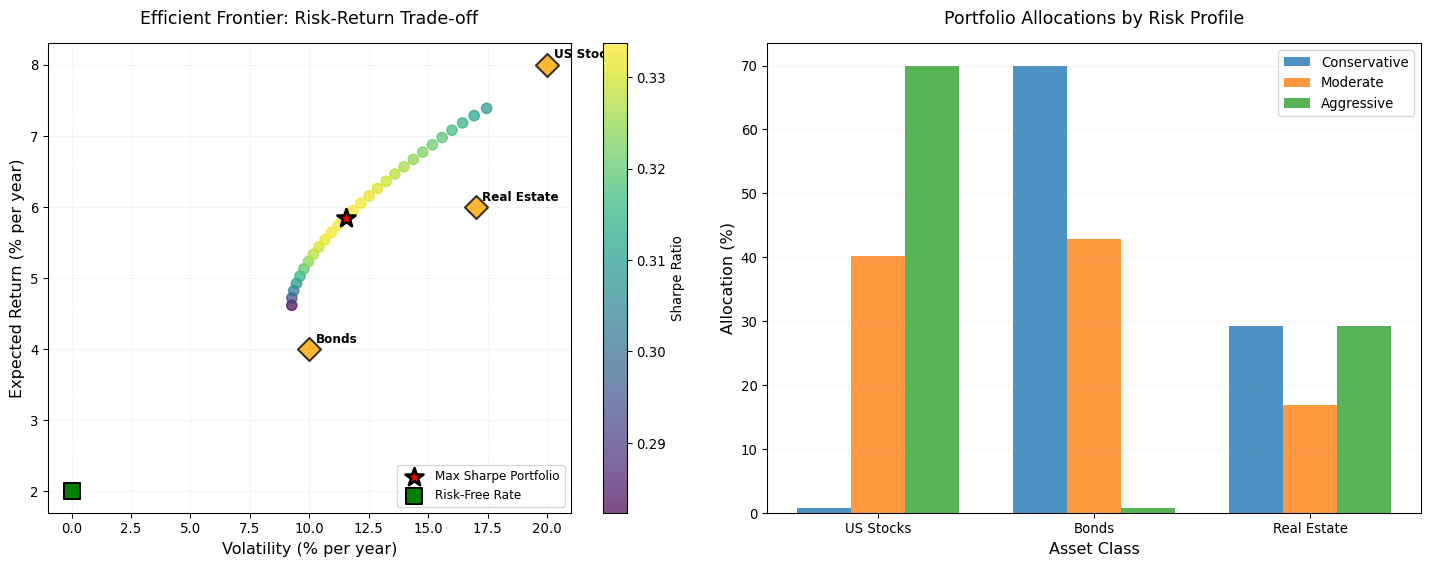


Risk Profile Portfolios:

Conservative Investor (Retiree, capital preservation):
  Target volatility: 8.0%
  Actual volatility: 9.26%
  Expected return:   4.62%
  Sharpe ratio:      0.28
  Allocation:
    Bonds                 70.0%
    Real Estate           29.2%

Moderate Investor (Mid-career, balanced growth):
  Target volatility: 12.0%
  Actual volatility: 11.84%
  Expected return:   5.95%
  Sharpe ratio:      0.33
  Allocation:
    US Stocks             40.3%
    Bonds                 42.8%
    Real Estate           16.9%

Aggressive Investor (Young investor, growth focus):
  Target volatility: 18.0%
  Actual volatility: 17.46%
  Expected return:   7.38%
  Sharpe ratio:      0.31
  Allocation:
    US Stocks             70.0%
    Real Estate           29.2%

✔ Efficient frontier analysis complete

In [4]:
def generate_efficient_frontier(robo_advisor, n_points=30):
    """
    Generate efficient frontier by varying target returns.
    
    The efficient frontier shows optimal portfolios—those achieving maximum 
    expected return for each risk level. This function solves multiple 
    constrained optimization problems, one for each target return level.
    
    Parameters
    ----------
    robo_advisor : RoboAdvisor
        Initialized robo-advisor instance containing:
        - expected_returns : expected annual returns for each asset
        - cov_matrix : covariance matrix of returns
        - risk_free_rate : annual risk-free rate for Sharpe calculation
    n_points : int, default=30
        Number of portfolios to compute along the frontier.
        More points = smoother curve but slower computation.
        
    Returns
    -------
    list of dict
        Each dictionary represents one efficient portfolio with keys:
        - 'volatility' : float, portfolio standard deviation (annualized)
        - 'return' : float, expected portfolio return (annualized)
        - 'sharpe' : float, Sharpe ratio = (return - rf) / volatility
        - 'weights' : ndarray, asset allocation weights (sum to 1.0)
        
    Notes
    -----
    - Uses scipy.optimize.minimize with SLSQP method
    - Constraints enforced: (1) weights sum to 1, (2) portfolio return = target
    - Asset weights bounded: 0 ≤ weight ≤ 0.70 (no shorting, max 70% concentration)
    - Only successful optimizations are returned (may return fewer than n_points)
    - Optimizations may fail for extreme target returns (too high/low given constraints)
    
    Examples
    --------
    >>> robo = RoboAdvisor(returns_df, risk_free_rate=0.02)
    >>> frontier = generate_efficient_frontier(robo, n_points=50)
    >>> len(frontier)  # May be less than 50 if some optimizations fail
    47
    >>> frontier[0]['return']  # Expected return of first portfolio
    0.085
    >>> frontier[0]['sharpe']  # Sharpe ratio
    1.23
    >>> np.sum(frontier[0]['weights'])  # Weights sum to 1.0
    1.0
    
    See Also
    --------
    RoboAdvisor.optimize_portfolio : Single portfolio optimization for given risk tolerance
    RoboAdvisor.portfolio_return : Calculate expected return for given weights
    RoboAdvisor.portfolio_volatility : Calculate portfolio risk for given weights
    """
    min_return = robo_advisor.expected_returns.min()
    max_return = robo_advisor.expected_returns.max()
    target_returns = np.linspace(min_return, max_return, n_points)
    
    frontier = []
    
    for target_ret in target_returns:
        def objective(weights):
            return robo_advisor.portfolio_volatility(weights)
        
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: robo_advisor.portfolio_return(w) - target_ret}
        ]
        
        bounds = [(0, 0.70) for _ in range(robo_advisor.n_assets)]
        initial = np.array([1/robo_advisor.n_assets] * robo_advisor.n_assets)
        
        result = minimize(objective, initial, method='SLSQP', 
                          bounds=bounds, constraints=constraints, 
                          options={'maxiter': 1000})
        
        if result.success:
            weights = result.x
            ret = robo_advisor.portfolio_return(weights)
            vol = robo_advisor.portfolio_volatility(weights)
            sharpe = (ret - robo_advisor.risk_free_rate) / vol if vol > 0 else 0
            
            frontier.append({
                'volatility': vol,
                'return': ret,
                'sharpe': sharpe,
                'weights': weights
            })
    
    return frontier

# Generate frontier
print("Generating efficient frontier...")
frontier = generate_efficient_frontier(robo, n_points=40)
print(f"✔ Generated {len(frontier)} efficient portfolios\n")

vols = np.array([p['volatility'] for p in frontier])
rets = np.array([p['return'] for p in frontier])
sharpes = np.array([p['sharpe'] for p in frontier])

max_sharpe_idx = np.argmax(sharpes)
max_sharpe_port = frontier[max_sharpe_idx]

# Simulate different investor risk profiles
risk_profiles = {
    'Conservative': {'risk_tolerance': 0.08, 'description': 'Retiree, capital preservation'},
    'Moderate': {'risk_tolerance': 0.12, 'description': 'Mid-career, balanced growth'},
    'Aggressive': {'risk_tolerance': 0.18, 'description': 'Young investor, growth focus'}
}

matched_portfolios = {}
for profile_name, profile in risk_profiles.items():
    target_vol = profile['risk_tolerance']
    closest_idx = np.argmin(np.abs(vols - target_vol))
    matched_portfolios[profile_name] = frontier[closest_idx]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Panel 1: Efficient Frontier
ax = axes[0]
scatter = ax.scatter(vols*100, rets*100, c=sharpes, cmap='viridis', s=60, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Sharpe Ratio')

ax.scatter(max_sharpe_port['volatility']*100, max_sharpe_port['return']*100, 
           color='red', s=200, marker='*', edgecolors='black', linewidths=2,
           label='Max Sharpe Portfolio', zorder=5)

for i, name in enumerate(asset_names):
    asset_vol = np.sqrt(cov_matrix[i, i]) * 100
    asset_ret = expected_returns[i] * 100
    ax.scatter(asset_vol, asset_ret, color='orange', s=150, marker='D', 
               edgecolors='black', linewidths=1.5, alpha=0.8, zorder=4)
    ax.annotate(name, (asset_vol, asset_ret), xytext=(5, 5), 
                textcoords='offset points', fontsize=9, fontweight='bold')

ax.scatter(0, robo.risk_free_rate*100, color='green', s=150, marker='s',
           edgecolors='black', linewidths=1.5, label='Risk-Free Rate', zorder=4)

ax.set_xlabel('Volatility (% per year)', fontsize=12)
ax.set_ylabel('Expected Return (% per year)', fontsize=12)
ax.set_title('Efficient Frontier: Risk-Return Trade-off', fontsize=13, pad=15)
ax.legend(fontsize=9, loc='lower right')
ax.grid(alpha=0.3, linestyle=':')

# Panel 2: Risk Profile Allocations
ax2 = axes[1]
profile_names = list(matched_portfolios.keys())
x_pos = np.arange(len(asset_names))
width = 0.25

for i, profile_name in enumerate(profile_names):
    portfolio = matched_portfolios[profile_name]
    weights = portfolio['weights'] * 100
    offset = (i - 1) * width
    ax2.bar(x_pos + offset, weights, width, label=profile_name, alpha=0.8)

ax2.set_xlabel('Asset Class', fontsize=12)
ax2.set_ylabel('Allocation (%)', fontsize=12)
ax2.set_title('Portfolio Allocations by Risk Profile', fontsize=13, pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(asset_names)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y', linestyle=':')

plt.tight_layout()
plt.show()

# Print risk profile details
print("\nRisk Profile Portfolios:")
print("=" * 80)
for profile_name, portfolio in matched_portfolios.items():
    desc = risk_profiles[profile_name]['description']
    print(f"\n{profile_name} Investor ({desc}):")
    print(f"  Target volatility: {risk_profiles[profile_name]['risk_tolerance']:.1%}")
    print(f"  Actual volatility: {portfolio['volatility']:.2%}")
    print(f"  Expected return:   {portfolio['return']:.2%}")
    print(f"  Sharpe ratio:      {portfolio['sharpe']:.2f}")
    print(f"  Allocation:")
    for asset, weight in zip(asset_names, portfolio['weights']):
        if weight > 0.01:
            print(f"    {asset:<20} {weight:>6.1%}")

print("\n✔ Efficient frontier analysis complete")

### Interpretation Guide

1.  **Frontier shape**: Why does the efficient frontier curve upward?
    Why does it get steeper at higher risk levels?

2.  **Max Sharpe portfolio**: Compare the max Sharpe portfolio to the
    three risk profiles. Which profile is closest?

3.  **Individual assets**: Notice individual assets plot *below* the
    frontier (except at endpoints). What does this tell you about
    diversification?

4.  **Risk profile allocations**: How do allocations change from
    Conservative → Moderate → Aggressive?

5.  **Robo-adviser questionnaire**: Real robo-advisers ask questions
    like “How would you react to a 20% portfolio loss?” How do you think
    they map answers to target volatility numbers?

Write 200–300 words explaining how robo-advisers use efficient frontiers
to match clients to portfolios.

## Task 4 — Sensitivity Analysis: What If We’re Wrong?

Portfolio optimisation requires estimates of expected returns and
covariances. But these estimates are uncertain. Let’s explore how
sensitive allocations are to input assumptions.

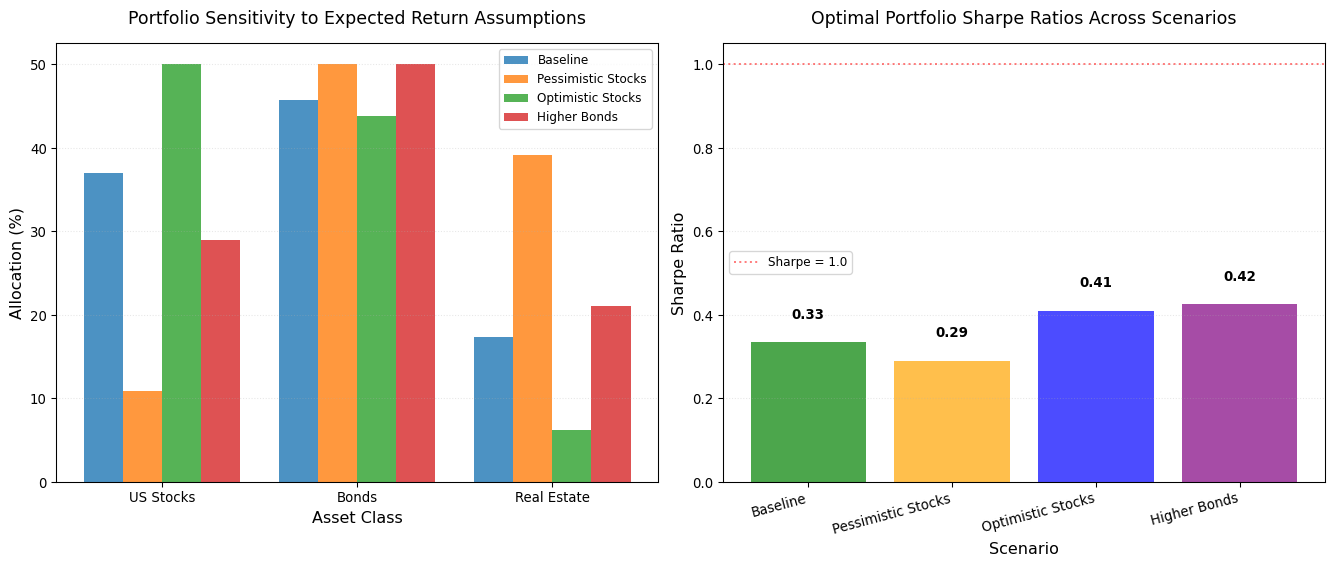


Scenario Analysis Results:
Scenario             Return     Volatility   Sharpe    
----------------------------------------------------------------------
Baseline                5.83%     11.46%     0.33
Pessimistic Stocks      5.00%     10.34%     0.29
Optimistic Stocks       7.12%     12.50%     0.41
Higher Bonds            6.58%     10.77%     0.42

✔ Sensitivity analysis complete

In [5]:
# Scenario analysis: vary expected returns
scenarios = {
    'Baseline': expected_returns,
    'Pessimistic Stocks': np.array([0.06, 0.04, 0.06]),
    'Optimistic Stocks': np.array([0.10, 0.04, 0.06]),
    'Higher Bonds': np.array([0.08, 0.06, 0.06]),
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Allocation sensitivity
ax = axes[0]
x_pos = np.arange(len(asset_names))
width = 0.2

for i, (scenario_name, exp_rets) in enumerate(scenarios.items()):
    robo_scenario = SimpleRoboAdvisor(asset_names, exp_rets, cov_matrix)
    portfolio = robo_scenario.optimize()
    weights = portfolio['weights'] * 100
    offset = (i - 1.5) * width
    ax.bar(x_pos + offset, weights, width, label=scenario_name, alpha=0.8)

ax.set_xlabel('Asset Class', fontsize=12)
ax.set_ylabel('Allocation (%)', fontsize=12)
ax.set_title('Portfolio Sensitivity to Expected Return Assumptions', fontsize=13, pad=15)
ax.set_xticks(x_pos)
ax.set_xticklabels(asset_names)
ax.legend(fontsize=9)
ax.grid(alpha=0.3, axis='y', linestyle=':')

# Panel 2: Sharpe ratio comparison
ax2 = axes[1]
scenario_names = list(scenarios.keys())
sharpe_ratios = []
returns = []
vols = []

for scenario_name, exp_rets in scenarios.items():
    robo_scenario = SimpleRoboAdvisor(asset_names, exp_rets, cov_matrix)
    portfolio = robo_scenario.optimize()
    sharpe_ratios.append(portfolio['sharpe_ratio'])
    returns.append(portfolio['expected_return'])
    vols.append(portfolio['volatility'])

x = np.arange(len(scenario_names))
ax2.bar(x, sharpe_ratios, alpha=0.7, color=['green', 'orange', 'blue', 'purple'])
ax2.set_xlabel('Scenario', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Optimal Portfolio Sharpe Ratios Across Scenarios', fontsize=13, pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=15, ha='right')
ax2.grid(alpha=0.3, axis='y', linestyle=':')
ax2.axhline(1.0, color='red', linestyle=':', alpha=0.5, label='Sharpe = 1.0')
ax2.legend(fontsize=9)

for i, v in enumerate(sharpe_ratios):
    ax2.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nScenario Analysis Results:")
print("=" * 70)
print(f"{'Scenario':<20} {'Return':<10} {'Volatility':<12} {'Sharpe':<10}")
print("-" * 70)
for i, scenario_name in enumerate(scenario_names):
    print(f"{scenario_name:<20} {returns[i]:>8.2%} {vols[i]:>10.2%} {sharpe_ratios[i]:>8.2f}")

print("\n✔ Sensitivity analysis complete")

### Interpretation Guide

1.  **Allocation changes**: When we lower stock expected returns from 8%
    to 6%, how does the allocation shift? Why?

2.  **Model risk**: Notice allocations can change significantly with
    small input changes. What does this tell you about the reliability
    of “optimal” portfolios?

3.  **Estimation error**: In reality, expected returns are very
    uncertain (forecasting error ~5% annually). What does this imply for
    portfolio recommendations?

4.  **Robo-adviser approach**: Most robo-advisers use historical returns
    or factor models. Neither is perfect. How should platforms
    communicate this uncertainty to clients?

Write 200–300 words discussing model risk and its implications for
governance (suitability, disclosure).

## Task 5 — Welfare and Inclusion Reflection (Directed Learning)

This is an extended reflection task for directed learning time. Connect
your quantitative findings to the empirical evidence and policy
questions.

### Deliverable

Write 400–500 words addressing:

1.  **Access expansion**: Using your Task 1 results, explain which
    investors benefit most from robo-adviser fee compression. Connect to
    Reher and Sokolinski (2024)’s finding that welfare gains are
    concentrated in the \$25K-\$150K wealth range.

2.  **Welfare magnitude**: Your 20-year compound savings calculations
    show substantial dollar amounts. But Reher & Sokolinski estimate
    welfare gains of only 0.3-0.7% of investable wealth. Why is the
    empirical estimate smaller than naive fee savings?

3.  **Who remains excluded**: Robo-advisers expand access, but ~40% of
    households still have no investable assets. What barriers remain?

4.  **Governance priorities**: Given your sensitivity analysis (Task 4),
    what governance mechanisms are most important? Rank: (a) suitability
    assessment, (b) disclosure of model limitations, (c) algorithmic
    bias auditing, (d) conflicts of interest management. Justify your
    ranking.

5.  **Policy question**: Should robo-advisers be held to the same
    fiduciary standard as human advisers? Discuss trade-offs.

Use at least two citations (e.g., Reher and Sokolinski (2024), Hilpisch
(2019) Ch. 13, or Vives (2019)).

## Quality Gate for Optimisation Results (5 minutes)

Before moving to interpretation, validate your portfolio optimisation:

In [6]:
# Run baseline optimisation
robo = SimpleRoboAdvisor(asset_names, expected_returns, cov_matrix)
portfolio = robo.optimize()

# Check 1: Weights sum to 1
weight_sum = np.sum(portfolio['weights'])
assert np.isclose(weight_sum, 1.0, atol=1e-4), f"Weights should sum to 1, got {weight_sum}"

# Check 2: No negative weights
assert np.all(portfolio['weights'] >= -1e-6), "No shorts allowed (check constraints)"

# Check 3: Max position respected
assert np.all(portfolio['weights'] <= 0.50 + 1e-4), "Max 50% position (check bounds)"

# Check 4: Sharpe ratio positive and reasonable
assert portfolio['sharpe_ratio'] > 0, "Sharpe should be positive"
assert portfolio['sharpe_ratio'] < 5, "Sharpe > 5 is unrealistic (check inputs)"

# Check 5: Volatility reasonable
assert 0.05 < portfolio['volatility'] < 0.30, "Volatility should be 5-30%"

# Check 6: Diversification
max_weight = np.max(portfolio['weights'])
assert max_weight < 0.80, f"Over-concentration: max weight = {max_weight:.1%}"

print("✔ All quality gate checks passed")
print("Your optimisation results are valid and ready for interpretation.")

✔ All quality gate checks passed
Your optimisation results are valid and ready for interpretation.

## Directed Learning Extensions

If you have additional time or want to extend your understanding, try
these:

### Extension 1: Tax-Loss Harvesting Simulation

Model a simple tax-loss harvesting strategy. Assume 25% capital gains
tax. Simulate a year where stocks fall 10%. Show how selling at a loss
and buying a similar asset generates tax savings.

### Extension 2: Rebalancing Analysis

Start with a 60/40 stock/bond portfolio. Simulate 5 years of returns
(stocks 8% avg, bonds 4% avg, with volatility). Show how portfolio
drifts from target. Implement annual rebalancing and compare terminal
wealth.

### Extension 3: Factor Model Returns

Replace historical expected returns with a Fama-French factor model.
Estimate factor loadings for your assets and use factor premiums to
predict returns. Compare allocations to baseline.

### Extension 4: Robo-Adviser Business Model

Calculate revenue for a robo-adviser with 100,000 clients, average
account size \$50K, fee 0.25%. Estimate costs (platform development
\$5M, operations \$2M/year). What’s the break-even client base?

## Assessment Integration

### FIN510 Coursework 1 — Set Exercises

Your lab work prepares you for Week 5 exercises, which may ask you to:

-   Calculate effective fee rates and break-even points
-   Explain access expansion using cost structure logic
-   Interpret portfolio optimisation outputs
-   Discuss governance challenges (suitability, model risk)

### FIN720 Coursework 1 — Reflective Analysis

Your lab interpretations are practice for the Week 7 essay, which asks
you to:

-   Evaluate robo-advisers as a FinTech innovation
-   Discuss welfare gains and inclusion (cite Reher and Sokolinski
    (2024))
-   Analyse governance and algorithmic bias
-   Use academic citations and empirical evidence

Use your Task 5 reflection as a building block for the coursework essay.

> **Troubleshooting**
>
> **Issue**: Optimisation fails or returns all-zero weights  
> **Solution**: Check that expected returns and covariance matrix are
> reasonable. Ensure covariance matrix is positive definite.
>
> **Issue**: Weights don’t sum to 1  
> **Solution**: Increase optimiser tolerance (ftol=1e-9) or check
> constraint definition.
>
> **Issue**: Results don’t match intuition  
> **Solution**: Double-check covariance matrix construction. High
> correlation can suppress allocation despite high expected return.

> **Further Reading (Hilpisch 2019)**
>
> -   **Chapter 13** (Portfolio Optimisation): Detailed implementation
>     using scipy.optimize, efficient frontier generation
> -   **Chapter 11** (Statistics): Return distributions, covariance
>     estimation
> -   **Chapter 15** (Valuation): Factor models, Fama-French, CAPM
>     extensions
>
> See: [Hilpisch Code Resources](../resources/hilpisch-code.qmd)

## Summary and Next Steps

You’ve now:

-   ✔ Compared cost structures and quantified access expansion
-   ✔ Implemented Modern Portfolio Theory optimisation
-   ✔ Generated efficient frontiers and matched risk profiles
-   ✔ Explored sensitivity to input assumptions (model risk)
-   ✔ Reflected on welfare, inclusion, and governance

Next steps:

1.  Complete your Task 5 reflection (400-500 words) connecting to theory
    and evidence
2.  Choose 1-2 directed learning extensions to explore further
3.  Read Reher and Sokolinski (2024) and Hilpisch (2019) Ch. 13 with
    your lab insights in mind
4.  Bring questions to next week’s seminar

**Well done! You’ve built hands-on understanding of robo-advisory
algorithms and their economic implications.**

Hilpisch, Yves. 2019. *Python for Finance*. 2nd ed. O’Reilly Media.
<https://www.oreilly.com/library/view/python-for-finance/9781492024330/>.

Reher, Michael, and Stanislav Sokolinski. 2024. “Robo-Advisors and
Access to Wealth Management.” *Journal of Financial Economics* 155:
103829. <https://doi.org/10.1016/j.jfineco.2024.103829>.

Vives, Xavier. 2019. “Digital Disruption in Banking.” *Annual Review of
Financial Economics*.
<https://doi.org/10.1146/annurev-financial-100719-120854>.